# Step 4 — Boid-on-Graph (Single Model, Medium Anchor Quality)

**Goal**  
Extend Step 3’s threshold-based movement into a *boid-inspired* model on a graph, while keeping the same purchase logic.  
We now run a **single model** with a *medium-quality anchor* to preserve diffusion and reveal local crowd effects.

---

### Why a single preset with *medium* anchor?

- A **high-quality anchor** collapses diffusion — agents cluster around it, hiding the effects of cohesion, separation, and alignment.  
- A **low-quality anchor** makes the system too uniform and weakens the anchor’s role.  
- A **medium-quality anchor** provides the most informative regime: diffusion remains active, the anchor still matters, and boid signals (cohesion, separation, alignment) visibly emerge — the closest setup to a realistic shopping mall environment.  

This setting keeps the model focused on **movement mechanics** rather than trivial “all-at-anchor” or “fully random” outcomes.

---

### What changed vs. Step 3

- **Boid terms on graph**  
  - *Cohesion* — move toward locally crowded neighbors  
  - *Separation* — avoid overly crowded neighbors  
  - *Alignment* — follow last popular choices  
- **Target / Love (goal-seeking)** — acts as a “carrot,” directing agents toward *complementary-category nodes* by favoring neighbors that move closer along the shortest path, blended with existing movement rules.  
- **Movement backbone unchanged** — same-category threshold (`θ_same`) → move/stay → *backup* complementary bias under threshold.  
- **Purchase rule unchanged** — complementary > similar > different/anchor.  
- **Diagnostics added** — per-node dominant boid term (*coh*, *sep*, *ali*, *love*), aggregated counts, and edge-level “love” activity tracking.

In [2]:
import os, sys

PROJECT_ROOT = os.path.abspath("..")  
sys.path.append(PROJECT_ROOT)
sys.path.append(os.path.join(PROJECT_ROOT, "src"))
sys.path.append(os.path.join(PROJECT_ROOT, "utils"))

print("Path added:", PROJECT_ROOT)

from asm.simulate_step4 import simulate, preset_A

from utils.io import ensure_dir

Path added: /workspaces/Modeling


In [3]:
# --- Run simulation with stronger love to visualize directed diffusion ---
from asm.simulate_step4 import preset_A, simulate
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

p = preset_A()
p.w_love = 1.6   # emphasize love effect for plotting
df, exit_df, A0, sim, diag = simulate(p)

print("Quick stats:", {k: round(v,3) if isinstance(v, float) else v for k,v in diag.items() if k in []})
print(df.sort_values("sales", ascending=False).head(8))

Quick stats: {}
    node    role       category  footfall  sales
1      1  tenant  complementary       216     68
0      0  anchor        similar       344     49
9      9  tenant        similar       206     42
18    18  tenant  complementary        65     30
10    10  tenant        similar       113     17
14    14  tenant      different        48      8
16    16  tenant  complementary        10      5
2      2  tenant  complementary        12      3


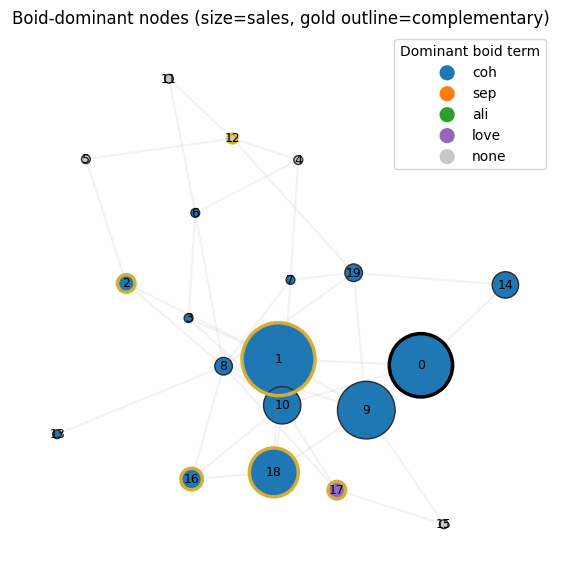

In [4]:
# --- Build layout once (deterministic) ---
G = sim.mall_graph
pos = nx.spring_layout(G, seed=42)

# color map for dominant term
term2color = {"coh":"#1f77b4","sep":"#ff7f0e","ali":"#2ca02c","love":"#9467bd","none":"#c7c7c7"}

# pick dominant term by node (fallback "none")
dom_by_node = {n: max(diag["dominant_term_by_node"].get(n, {"none":0}), key=lambda k: diag["dominant_term_by_node"].get(n, {}).get(k,0))
               for n in G.nodes}

# node sizes by sales
sizes = (df.set_index("node")["sales"] + 1) * 40

# base nodes
node_colors = [term2color.get(dom_by_node[n], "#c7c7c7") for n in G.nodes]

plt.figure(figsize=(7,7))
nx.draw_networkx_edges(G, pos, alpha=0.25, width=1.5, edge_color="#cccccc")
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=sizes, linewidths=1.0, edgecolors="#2b2b2b")

# --- highlight complementary nodes with golden outline ---
comp_nodes = diag["comp_nodes"]
nx.draw_networkx_nodes(G, pos, nodelist=comp_nodes, node_size=sizes[comp_nodes], 
                       node_color="none", edgecolors="#d4af37", linewidths=2.5)

# anchor halo
nx.draw_networkx_nodes(G, pos, nodelist=[A0], node_size=sizes[A0]+80, node_color="none",
                       edgecolors="#000000", linewidths=2.5)

nx.draw_networkx_labels(G, pos, labels={n:str(n) for n in G.nodes}, font_size=9)

# legend dots
for i,(k,c) in enumerate(term2color.items()):
    plt.scatter([],[], s=120, c=c, label=k, edgecolors="none")
plt.legend(title="Dominant boid term", loc="upper right")

plt.title("Boid-dominant nodes (size=sales, gold outline=complementary)")
plt.axis("off")
plt.show()

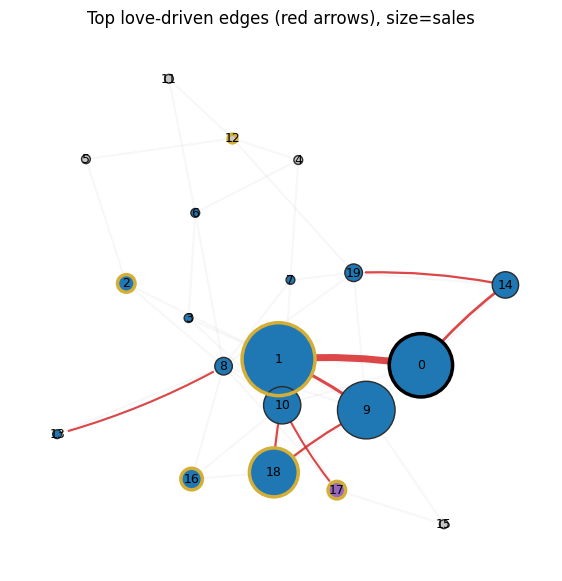

In [5]:
# --- Draw top-K love edges as red arrows (where love actually chose the step) ---
from math import sqrt

love_edges = diag["love_edges"]          # {(u,v): count}
if love_edges:
    K = 8  # show top-K
    top = sorted(love_edges.items(), key=lambda x: x[1], reverse=True)[:K]

    # scale width by count
    counts = np.array([c for _,c in top], dtype=float)
    widths = 1.5 + 3.5 * (counts - counts.min()) / max(1, (counts.max()-counts.min()))

    plt.figure(figsize=(7,7))
    nx.draw_networkx_edges(G, pos, alpha=0.15, width=1.5, edge_color="#cccccc")
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=sizes, linewidths=1.0, edgecolors="#2b2b2b")
    nx.draw_networkx_nodes(G, pos, nodelist=comp_nodes, node_size=sizes[comp_nodes], 
                           node_color="none", edgecolors="#d4af37", linewidths=2.5)
    nx.draw_networkx_nodes(G, pos, nodelist=[A0], node_size=sizes[A0]+80, node_color="none",
                           edgecolors="#000000", linewidths=2.5)
    nx.draw_networkx_labels(G, pos, labels={n:str(n) for n in G.nodes}, font_size=9)

    # red arrows for love-driven steps
    for (idx, ((u,v), cnt)) in enumerate(top):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u,v)],
            width=widths[idx],
            edge_color="#d62728",
            arrows=True,
            arrowsize=18,
            connectionstyle="arc3,rad=0.06",
            alpha=0.85,
        )

    plt.title("Top love-driven edges (red arrows), size=sales")
    plt.axis("off")
    plt.show()
else:
    print("No love-driven edges recorded in this run (try p.w_love ↑ or more steps).")

## Key Observations

1. **Cohesion** dominates across most nodes — agents tend to move toward locally crowded areas.  
   → This mirrors realistic mall behavior, where people are attracted to busy zones.  

2. **Love (goal-seeking toward complementary nodes)** appears selectively at certain complementary stores.  
   → These nodes (e.g., cafes, accessory shops) form bridges that connect anchor stores with other zones, as shown by the **red arrows**.

3. **Red arrows (love-driven edges)** are concentrated around the anchor (0) and central nodes (1, 10).  
   → Complementary nodes near the anchor act as *spillover hubs* facilitating flow between clusters.

4. **Gold-outlined complementary nodes** overlap with high-sales nodes, indicating that purchase activity and complementary movement reinforce each other.

---

## Interpretation

- The **Cohesion rule** primarily drives local movement, while the **Love term** activates selectively, directing agents toward complementary stores.  
- As a result, customers cluster in popular zones yet diffuse outward along complementary pathways.  
- This pattern reflects realistic mall dynamics, where **anchor-driven traffic** spreads through **complementary categories** rather than random dispersion.  
- Complementary nodes thus play a key structural role — stabilizing and extending overall **sales diffusion** across the network.
